In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [3]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [7]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        # 处理新版本Gym可能返回的元组格式 (observation, info)
        if isinstance(state, tuple) and len(state) == 2:
            # 提取观察值，忽略信息字典
            state = state[0]
        
        if isinstance(state, np.ndarray):
            state = state.astype(np.float32)
        else:
            # 对于非numpy数组，先转换为numpy数组并展平
            state = np.array(state, dtype=np.float32)
            if state.ndim > 1:
                state = state.flatten()
        
        # 转换为PyTorch tensor
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        # 更安全地处理状态数组转换
        states = torch.tensor(np.array(transition_dict['states'], dtype=np.float32),
                                  dtype=torch.float).to(self.device)
        
        actions = torch.tensor(np.array(transition_dict['actions']), dtype=torch.long).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']),
                               dtype=torch.float).view(-1, 1).to(self.device)
        
        next_states = torch.tensor(np.array(transition_dict['next_states'], dtype=np.float32),
                                       dtype=torch.float).to(self.device)
        
        dones = torch.tensor(np.array(transition_dict['dones']),
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # 均方误差损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数

In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cpu") 

env_name = 'CartPole-v1'  # 使用更新的版本
env = gym.make(env_name, render_mode=None)

# 新版本Gym的种子设置方式
env.reset(seed=0)
env.action_space.seed(0)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 100/100 [00:06<00:00, 16.24it/s, episode=1000, return=500.000]


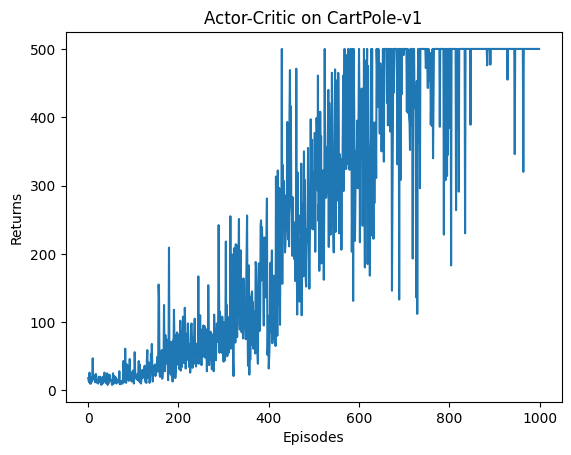

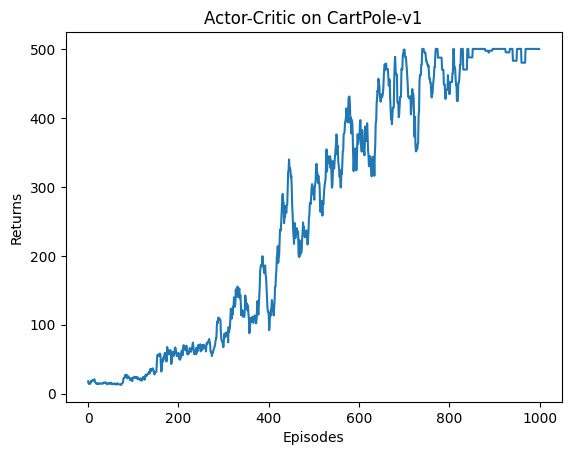

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

In [ ]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        # 处理新版本Gym可能返回的元组格式 (observation, info)
        if isinstance(state, tuple) and len(state) == 2:
            # 提取观察值，忽略信息字典
            state = state[0]
        
        if isinstance(state, np.ndarray):
            state = state.astype(np.float32)
        else:
            # 对于非numpy数组，先转换为numpy数组并展平
            state = np.array(state, dtype=np.float32)
            if state.ndim > 1:
                state = state.flatten()
        
        # 转换为PyTorch tensor
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        # 更安全地处理状态数组转换
        states = torch.tensor(np.array(transition_dict['states'], dtype=np.float32),
                                  dtype=torch.float).to(self.device)
        
        actions = torch.tensor(np.array(transition_dict['actions']), dtype=torch.long).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']),
                               dtype=torch.float).view(-1, 1).to(self.device)
        
        next_states = torch.tensor(np.array(transition_dict['next_states'], dtype=np.float32),
                                       dtype=torch.float).to(self.device)
        
        dones = torch.tensor(np.array(transition_dict['dones']),
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # 均方误差损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数